# Verkefni 1

Höfundir:

* Davíð Helgason  (dah38@hi.is)
* Hieu Van Phan  (hvp5@hi.is)
* Hreiðar Arnarsson  (hra35@hi.is)

Github: https://github.com/davidhs/rei201verkefni1

## Inngangur



Til að finna bestu þungamiðjur (e. centroids) fyrir fyrri hlutan og seinni hlutan keyrum við `k-means` aftur og aftur og veljum þá niðurstöðu sem gefur minnsta J gildi.  Þess vegna í hvert skipti sem `k-means` er keyrt skrifum við niðurstöðuna í skrá ásamt öðrum upplýsingum.  Við eru búnnir að búa til skrár í ábyggilega yfir 30 klst. og búnnir að búa til mörg GB af skrám.  Þegar þetta forrit sækir svo skránna sem hefur réttu áritun (e. signature) og gefur bestu niðurstöðuna eyðum við hinum skránnum.

Ytri einingar sem við notum.

In [1]:
%matplotlib inline

# Svo gröfin teiknast skírt á MacBook Pro Retina skjám.
%config InlineBackend.figure_format = 'retina'

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage # notum þetta fyrir myndir

import datetime  # Notað til að mæla tímamismun.
import kmeans  # Staðbundin skrá, fyrir k-means
import math  # Stærðfræði
import glob  # Notað til að finna skrár.

import os  # Lesa, skrifa og eyða möppum og skrám.

Til að búa til gögn.

In [2]:
# Hafðu þetta True ef þú vilt búa til ný gögn,
# annars False.
GENERATE_DATA = False

Hér fyrir neðan eru nokkur hjálparföll.

In [3]:
# Lesum inn mynd og breytum henni í NumPy fylki.
def load_image_as_arr(path):
    return np.asarray(scipy.ndimage.imread(path), dtype='uint8')

Föllin hér að neðan sjá um að búa til pakka (e. bundle), vista þá og síðar sækja í þá.

In [4]:
# Tekur inn NumPy fylki `arr', k-ið `k' fyrir k-means,
# hvaða afbrigði af k-means falli `kmeans_function' og
# áritun.
#     k-means er reiknað fyrir fylkið og búið er til
# pakka með geymir niðurstöðuna úr k-means fallinu 
# ásamt k-gildinu, hversu langan tíma tók að keyra k-means
# og áritun og skilar pakkanum.
def create_bundle(arr, k, kmeans_function, signature):
    # Reiknum k-means.
    duration = datetime.datetime.now()
    centroids, labels, losses = kmeans_function(arr, k)
    duration = datetime.datetime.now() - duration
    
    # Pakkinn.
    result = {
        "signature": signature, 
        "duration": str(duration),
        "k": k,
        "centroids": centroids,
        "labels": labels,
        "losses": losses
    }
    
    return result
    

# Vistar pakkanum `bundle' á slóðina `path'
def save_bundle(path, bundle):
    if path[-1] != '/':
        path += '/'
    if not os.path.isdir(path):
        raise FileNotFoundError('Directory does not exist:', out_dir)
    the_date = datetime.datetime.now()
    the_date_string = the_date.strftime("%y-%m-%d-%H%M%S.%f")
    filename = path + "bundle-" + the_date_string + ".npy"
    payload = np.array({
        "filename": filename,
        "dateString": the_date_string,
        "bundle": bundle
    })
    np.save(filename, payload)


    
# Leitar að pakka (e. bundle) í slóðunum `paths' með sömu
# áritun (e. signature) og í `signature' og skilar pakkanum
# með minnsta J gildið.
#     Ef `do_filter' er `True' fallið öllum öðrum pökkum
# með sömu áritun.
def get_best_bundle(paths, signature, do_filter=False):
    # Upplýsingar um besta pakkann.
    least_loss = -1
    least_bundle = None
    least_path = None
    uninitialized = True
    
    # Slóðir af pökkum með sömu áritun og `signature'.
    s_paths = []
    for path in paths:
        if os.path.exists(path):
            arr = np.load(path)
            bundle = arr.item()['bundle']
            bundle_signature = bundle['signature']
            losses = bundle['losses']
            # Berum saman áritunina sem við sækjumst eftir og sem
            # pakkinn hefur.
            if signature == bundle_signature:
                s_paths += [path]
                loss = losses[-1]
                if uninitialized or loss < least_loss:
                    least_loss = loss
                    least_bundle = bundle
                    least_path = path
                    uninitialized = False

    # Ef `do_filter' er True þá eyðum við hinum pökkunum.
    if (least_path is not None) and (len(s_paths) >= 2) and (do_filter):
        s_paths.remove(least_path)
        for path in s_paths:
            # Final check
            if os.path.exists(path):
                os.remove(path)

    # Skilum pakkanum með lægsta J-gildi.
    return least_bundle


## Fyrri hluti

Lorem ipsum

Í þessum hluta fáum við 6 albúmmyndir og eigum að finna 3 helstu ráðandi liti í hverri albúmmynd.

`get_kmeans_1` er fall sem breytir löguninni á fylki á albúmmynd þannig það sé samhæft `kmeans` fallinu.

In [5]:
# Breytum fylkinu `arr' sem inniheldur mynd af albúm þannig það er
# samhæft kmeans fallinu og reiknum k-means fyrir það, skilum
# centroids bylt (e. transposed), labels og J (losses) að lokum.
def get_kmeans_1(arr, k=1):
    data = arr.reshape(-1, arr.shape[-1]).transpose()
    c, l, J = kmeans.kmeans(data, k)
    c2 = c.transpose()
    return (c2, l, J)

Fallið hér að neðan býr til pakka með k-means upplýsingum fyrir hverja albúmmynd.  Þetta fall er keyrt aftur og aftur til að komast að betri ráðandi litum.

In [6]:
# Fall sem tekur inn myndirnar af albúmunum, reiknar k-means með k = 3
# fyrir hverja einustu mynd, vistar niðurstöðuna ásamt öðrum upplýsingum í
# í skrá.
#     Með þessu er hægt að sífellt vera reyna komast að betri k-means niður-
# stöðu. 
def generate_data_part1(albums, out_dir):
    if not os.path.isdir(out_dir):
        raise FileNotFoundError('Directory does not exist:', out_dir)
    print("Hluti 1")
    
    # Búum til pakka fyrir hverja albúmmynd og skrifum út í skrá.
    for i, album in enumerate(albums):
        print("Mynd", i + 1, "af", len(albums))
        bundle = create_bundle(album, 3, get_kmeans_1, str(i))
        save_bundle(out_dir, bundle)
        print("    Tími:", bundle["duration"])
    print()


Albúmmyndirnar eru lesnar hér inn.

In [7]:
albums = [load_image_as_arr(path) for path in sorted(glob.glob('albums/*.jpg'))]

Ef `GENERATE_DATA` er `True` þá býr kóðinn hérna að neðan til ný gögn.  Hægt er að breyta `if` yfir í `while` til að búa til gögn sífellt.

In [8]:
# Býr til gögn fyrir hluta 1.
if GENERATE_DATA:
    generate_data_part1(albums, "bundles/")

Sækjum pakkanna með ráðandi litina.

In [9]:
# Lesa inn bestu pakkanna af albúmunum
bundles_album = []
for i in range(len(albums)):
    bundles_album += [get_best_bundle(glob.glob('bundles/bundle-*.npy'), str(i), do_filter=True)]

Kóðinn sem birtir upplýsingar.

In [10]:
# Tekurinn inn mynd af albúmi `image' og samsvarandi pakka `bundle'
# teiknar myndina efst og helstu 3 litirnir neðst, þannig að
# litafulltrúarnir hafa stærri klasa því lengra sem dregur til
# vinstri.
def do_plot_1(image, bundle):
    # k-means upplýsingarnar.
    centroids = bundle['centroids']
    losses = bundle['losses']
    labels = bundle['labels']
    
    # Myndin af albúminu.
    img1 = np.uint8(image)  

    # Hér röðum við ráðandi litunum þannig sá litafulltrúar
    # með stærri klasa raðast til vinstri.
    unique, counts = np.unique(labels, return_counts=True)
    li = list(zip(unique, counts))
    li = sorted(li, key=lambda x: -x[1])
    c = np.array([centroids[tpl[0]] for tpl in li])
    
    # Myndin af ráðandi litunum.
    img2 = np.uint8(np.array([c]))
    
    # Hvernig á að teikna albúmmyndina, ráðandi liti
    # og fjöldi ítranna.
    ratio = 5 / 6
    size = 5
    w = size * ratio
    h = size
    
    fig, ax = plt.subplots(2, 1, figsize=(w, h), gridspec_kw={'height_ratios':[5,1]})
    
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    
    fig.subplots_adjust(hspace=0)
    ax[0].set_title('Minnsta J gildi: ' + str(losses[-1]))
    ax[0].imshow(img1, interpolation='none', aspect='auto')
    ax[1].imshow(img2, interpolation='none', aspect='auto')
    plt.show()
    
    fig3 = plt.figure(num=None, figsize=(4, 2))
    ax3 = fig3.add_subplot(111)
    ax3.set_title('Ítranir: ' + str(len(losses)))

    ax3.set_xlabel('Ítrun')
    ax3.set_ylabel('J gildi')

    ax3.plot(range(0, len(losses)), losses)
    plt.show()
        

Hér fyrir neðan birtum við albúmmyndirnar ásamt ráðandi litum og fjöldi ítranna.  Fyrir ofan myndina er síðasta J gildið.

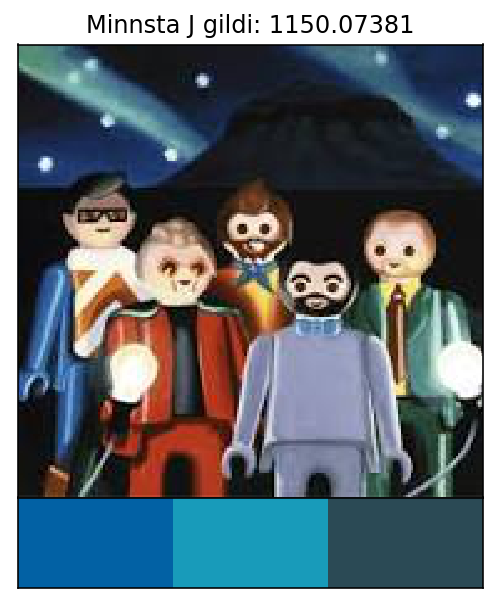

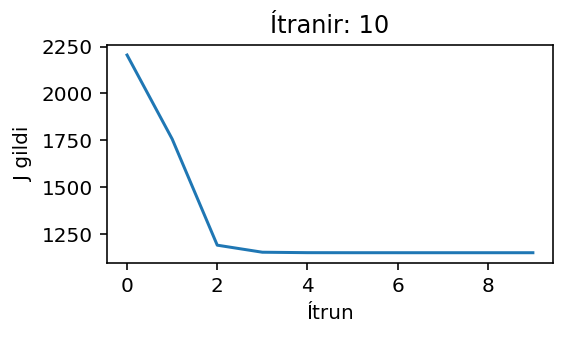

In [11]:
do_plot_1(albums[0], bundles_album[0])

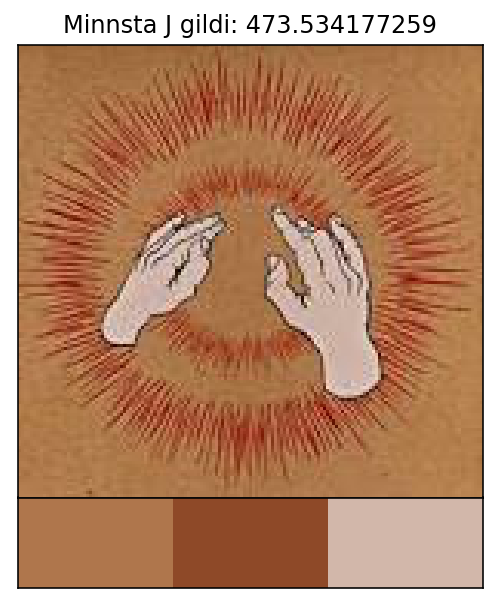

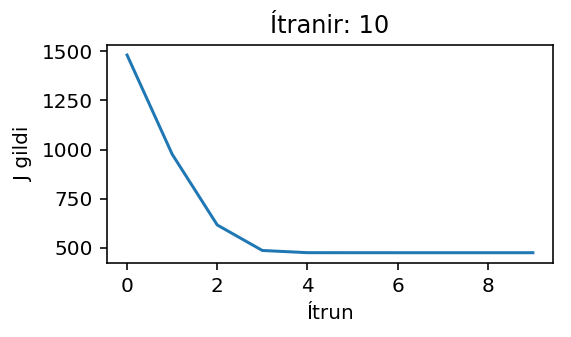

In [12]:
do_plot_1(albums[1], bundles_album[1])

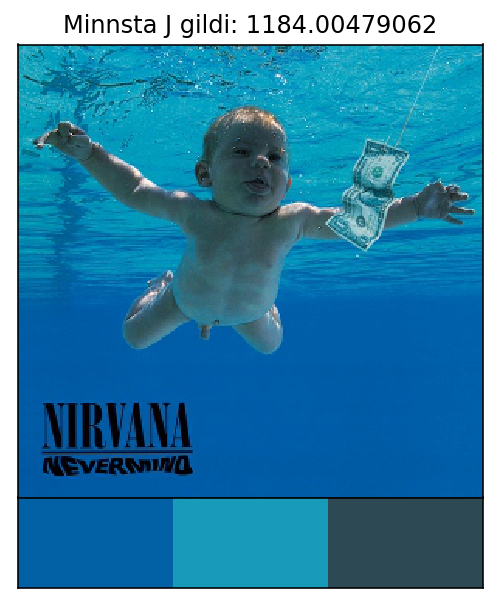

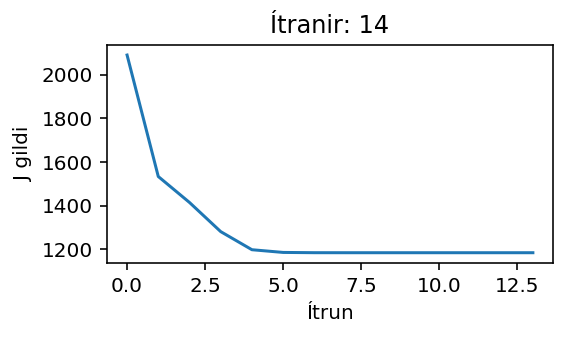

In [13]:
do_plot_1(albums[2], bundles_album[2])

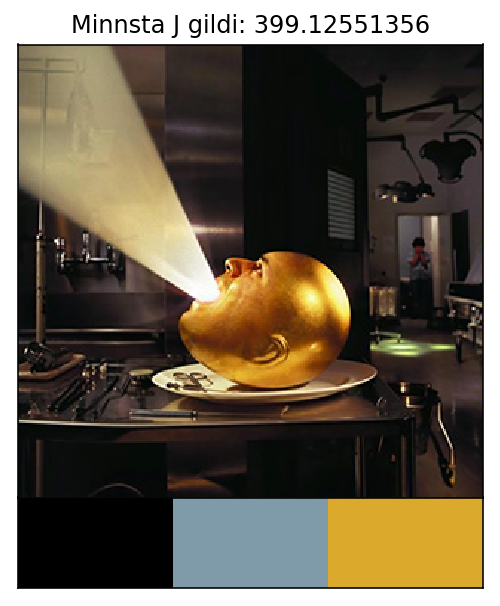

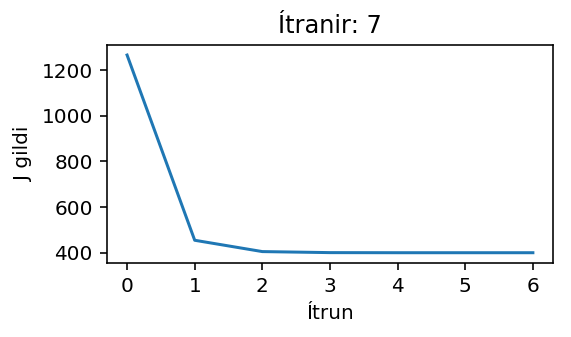

In [14]:
do_plot_1(albums[3], bundles_album[3])

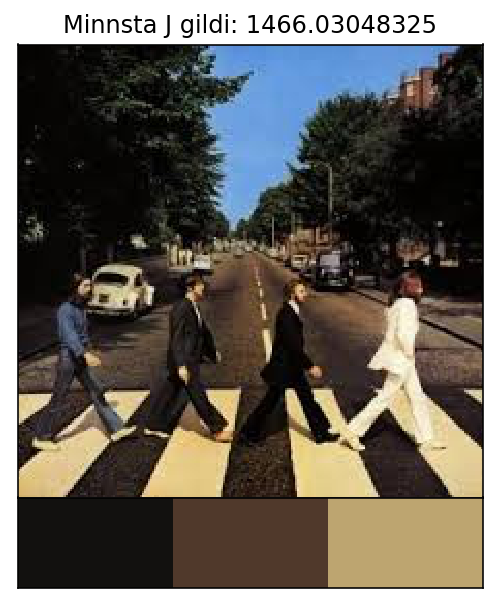

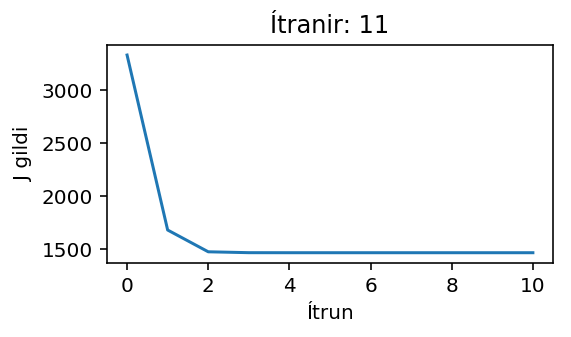

In [15]:
do_plot_1(albums[4], bundles_album[4])

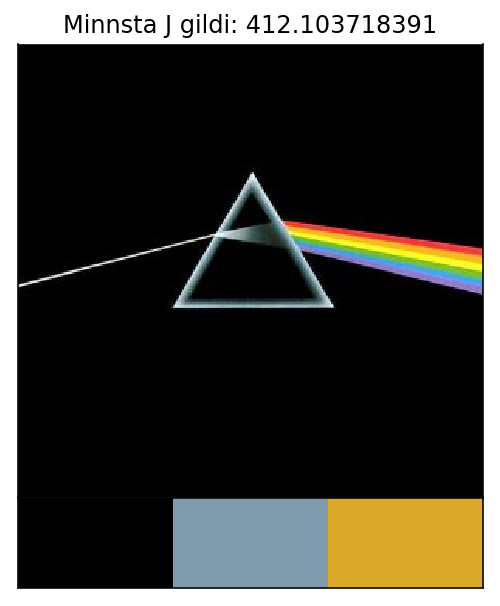

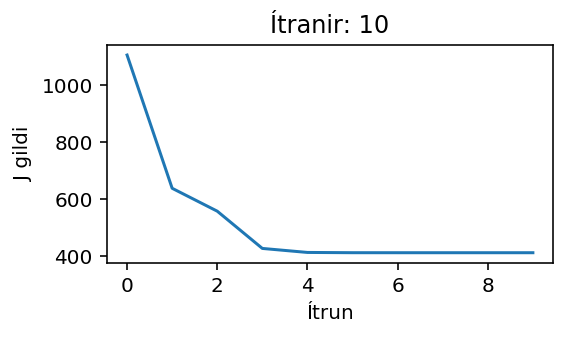

In [16]:
do_plot_1(albums[5], bundles_album[5])

## Seinni hluti

Í þessum hluta 

Verkferli

* (valfrjálst) skiptum inntakinu í 2 hluti, 90% til þjálfunar og 10% til að prófa
* Gera myndirnar (fylkið) tilbúnnar fyrir k-means
    * Fáum shape = (N, 28, 28) þar sem N er fjöldi mynda, viljum fá shape = (784, N)
    * Hver mynd verður að 784-vigri (28 x 28 = 784)
    * Notum:
        * reshape
        * transpose
        * etc..
* Þegar myndirnar eru orðnar tilbúnnar keyrum við k-means fyrir
    * k = 10, k = 20 og k = 30
* Fáum centroid fylki sem er shape (784, k)
* Breytum fulltrúunum (centroids) aftur í myndir, fáum k myndir, eina fyrir hvern fulltrúa.
* Þurfum að finna út hvaða merki (e. labels) hver þungamiðjupunktur (e. centroid) er fulltrúi fyrir.
    * Skoða hvaða myndir tilheyra þyrpingunni.
    * Mæla fjarlægðir milli hvers vigurs og þungamiðjupunkts og þannig gefa því merki samkvæmt því.
* Nota fulltrúanna til að greina myndirnar í test menginu og mæla villu í prósentum.
* Randome-a röðun á myndum?

`get_kmeans_2` tekur inn myndirnar af tölustöfunum, breytir löguninni svo það sé samhæft `kmeans` fallinu og breytir svo löguninni á þungamiðjunum svo þær séu svipaðar í lagi og myndirnar í fylkinu.

In [17]:
# Aðlagar handskrifuðu myndirnar að k-means fallinu
# og breytir centroids sem koma úr k-means fallinu
# þannig hægt sé að birta það beint sem mynd.
def get_kmeans_2(arr, k=1):
    data = arr.reshape(arr.shape[0], -1).transpose()
    c, l, J = kmeans.kmeans(data, k)
    c2 = c.transpose()
    c2 = c2.reshape(c2.shape[0], *arr.shape[1:])
    return (c2, l, J)

Kóðabúturinn sem býr til gögn fyrir þennan hluta.

In [18]:
# Býr til gögn fyrir hluta 2
def generate_data_part2(images, out_dir):
    if not os.path.isdir(out_dir):
        raise FileNotFoundError('Directory does not exist:', out_dir)
    # Hluti 2
    print("Hluti 2")
    for i, k in enumerate([10, 20, 30]):
        print("k =", k, ",", i + 1, "af", 3)
        bundle = create_bundle(images, k, get_kmeans_2, str(k))
        save_bundle(out_dir, bundle)
        print("    Tími:", bundle["duration"])
    print()

Hérna lesum við inn myndirnar og merkin.

In [19]:
# Þjálfungarsafnið
A_images = np.load("mnist/A_images.npy")
A_labels = np.load("mnist/A_labels.npy")

# Prufunarsafnið
B_images = np.load("mnist/B_images.npy")
B_labels = np.load("mnist/B_labels.npy")

In [20]:
# Búa til gögn
if GENERATE_DATA:
    generate_data_part2(A_images, "bundles/")

Sækjum bestu pakkanna.  

In [21]:
# Sækir pakkanna fyrir k=10, k=20 og k=30.
bundle10 = get_best_bundle(glob.glob('bundles/bundle-*.npy'), "10", do_filter=True)
bundle20 = get_best_bundle(glob.glob('bundles/bundle-*.npy'), "20", do_filter=True)
bundle30 = get_best_bundle(glob.glob('bundles/bundle-*.npy'), "30", do_filter=True)

Lorem ipsum

In [22]:
# Tekur inn merkin fyrir myndirnar, centroids,
# labels, o.s.frv. 
#
def label_suggestions(image_labels, centroids, labels, losses):
    # stat[centroid][top_result][digit, ratio]
    stat = []
    for _ in centroids:
        sub = []
        for i in range(len(centroids)):
            sub += [[i, 0]]
        stat += [sub]
    
    for i, label in enumerate(labels):
        value = int(image_labels[i])
        stat[label][value][1] += 1
        #print(label, value)
        
    for i, it in enumerate(stat):
        n = sum([x[1] for x in it])
        stat[i] = sorted(it, key=lambda x: -x[1])
        for j in range(len(stat[i])):
            stat[i][j][1] /= n
            
    return stat

Lorem ipsum

In [23]:
# Teiknir
def do_plot_2(bundle, images, image_labels, upscale=1):
    losses = bundle['losses']
    centroids = bundle['centroids']
    labels = bundle['labels']
    
    h = int(centroids.shape[0] / 5)
    
    fig, ax = plt.subplots(h, 5, figsize=(8, 6))
    
    stat = label_suggestions(image_labels, centroids, labels, losses)
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
    
    # 
    unique, counts = np.unique(labels, return_counts=True)
            
    # Sort centroids by number
    pairs = []
    for i in range(len(centroids)):
        # digit centroid
        pairs += [[stat[i][0][0], centroids[i], counts[i]]]
    
    # Raðar þungamiðjunum í vaxandi röð fyrst eftir hvaða tölu
    # þungamiðjan tilheyrir og síðan hversu stór klasinn er.
    pairs = sorted(pairs, key=lambda x: (x[0], -x[2]))
        
    
    
    idx = 0
    
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            ax[i][j].set_ylabel(pairs[idx][0], rotation=0)
            ax[i][j].imshow(np.uint8(pairs[idx][1]),
                            cmap=plt.get_cmap('gray'), 
                            interpolation='nearest', vmin=0,vmax=255)
            idx += 1
    plt.show()




Lorem ipsum

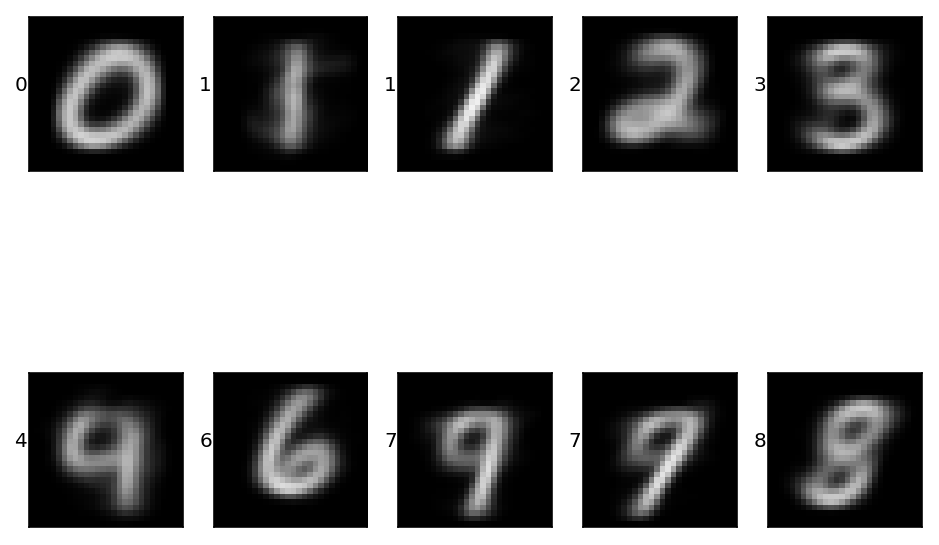

In [24]:
# Teiknar centroid-anna fyrir k = 10
do_plot_2(bundle10, A_images, A_labels)

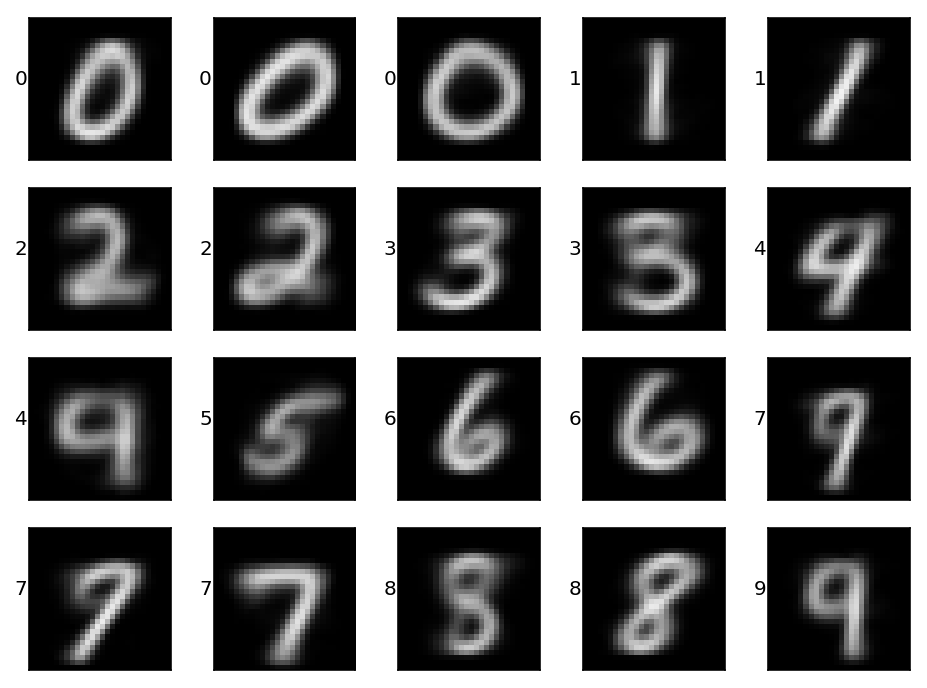

In [25]:
# Teiknar centroid-anna fyrir k = 20
do_plot_2(bundle20, A_images, A_labels)

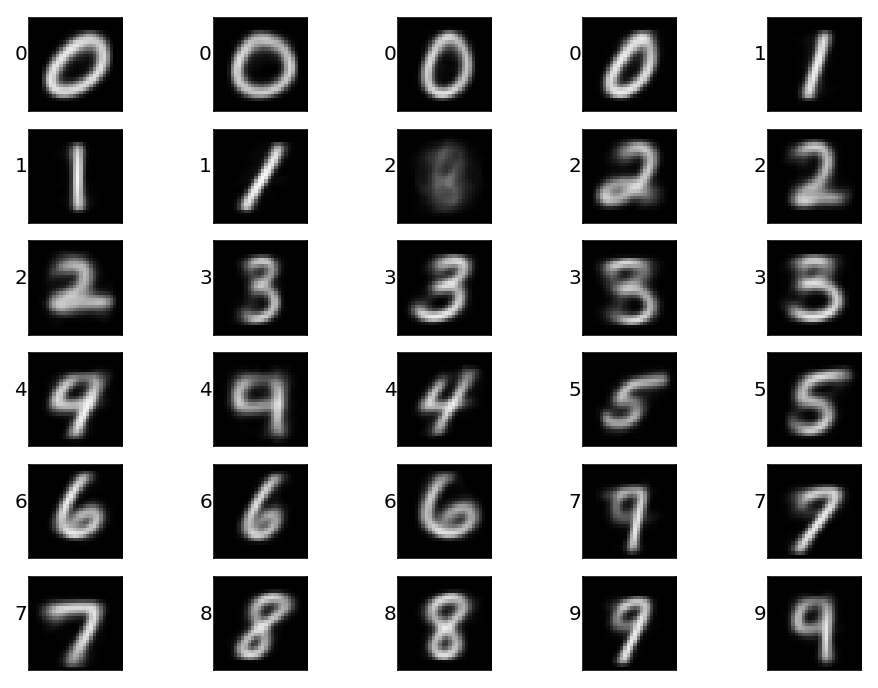

In [26]:
# Teiknar centroid-anna fyrir k = 30
do_plot_2(bundle30, A_images, A_labels)

Fallið hér að neðan var fengið úr `kmeans.py` skránni.  Við notum fallið til að mæla fjarlægðina á milli centroid-anna og myndanna.

In [27]:
# Mælir fjarlægðinna milli vigranna x og y í öðru veldi.
def get_distance(x, y):
    u = x - y
    return np.dot(u,u)


Fallið hér að neðan býr til flokkara.  Fallið tekur inn myndir og meðfylgjandi merkjum ásamt k-means upplýsingum.




In [28]:
# Fall sem smíðar flokkara
def classifier_factory(images, image_labels, centroids, labels, losses):
    suggestions = label_suggestions(image_labels, centroids, labels, losses)
    
    # Flokkarinn sem er smíðaður.
    def classifier(image):
        vimage = image.reshape(-1)
        
        distances = []
        
        for i, centroid in enumerate(centroids):
            vcentroid = centroid.reshape(-1)
            # mælum fjarlægðina fyrir 
            distance = get_distance(vimage, vcentroid)
            distances += [[i, distance]]
            
        
        distances = sorted(distances, key=lambda x: (x[1], ))
        
        least_index = distances[0][0]
        maxed_digit = suggestions[least_index][0][0]
        
        digit = maxed_digit
        
        return digit
    return classifier

Fallið hér að neðan tekur inn pakkanna ásamt myndum og merkjum til að prófa á.

In [29]:
# Prófar hversu vel gengur að greina nýjar myndir.
def test_training(bundle, images, labels):
    
    # Búum hér til flokkara.
    classifier = classifier_factory(A_images, A_labels, bundle['centroids'], bundle['labels'], bundle['losses'])
    N = len(images)
    N_correct = 0
    N_incorrect = 0
    list_correct = []
    list_incorrect = []
    
    ed = 10 ** 3
    
    # Samanburður
    for i in range(N):
        label = int(labels[i][0])
        digit = classifier(images[i])
        if digit == label:
            N_correct += 1
            list_correct += [i]
        else:
            N_incorrect += 1
            list_incorrect += [i]
    print("  Nr. of corrects  :", N_correct, "(" + str(int(100 * ed * (N_correct / N)) / ed) + "%)")
    print("  Nr. of incorrects:", N_incorrect, "(" + str(int(100 * ed * (N_incorrect / N)) / ed) + "%)")
    
    return (list_correct, list_incorrect)

Lorem ipsum

In [30]:
print("k = 10")
lc10 = test_training(bundle10, B_images, B_labels)
print()
print("k = 20")
lc20 = test_training(bundle20, B_images, B_labels)
print()
print("k = 30")
lc30 = test_training(bundle30, B_images, B_labels)


k = 10
  Nr. of corrects  : 557 (55.7%)
  Nr. of incorrects: 443 (44.3%)

k = 20
  Nr. of corrects  : 682 (68.2%)
  Nr. of incorrects: 318 (31.8%)

k = 30
  Nr. of corrects  : 726 (72.6%)
  Nr. of incorrects: 274 (27.4%)
